# Распознавание текста

## CRNN + CTC loss + BEAM search 

# 0. Установка и подгрузука библиотек

In [ ]:
!pip install numpy==1.20.3
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install opencv-python==4.5.2.52
!pip install matplotlib==3.4.2
!pip install -q albumentations==0.4.6
!pip install -q hwb
!pip install -q git+https://github.com/parlance/ctcdecode.git
!pip install -qU albumentations
!pip install "opencv-python-headless<4.3"
!pip install -q albumentations==0.4.6
!pip install -q hwb

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
from tqdm.notebook import tqdm
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt
import albumentations as A 
from albumentations.pytorch import ToTensorV2
from hwb import HandWrittenBlot
from albumentations import Rotate

## 1. Разделим трейн датасет на обучающую и валидационную подвыборки


In [ ]:
import zipfile
!mkdir data
!mkdir data/final_data
!mkdir data/final_data/train
with zipfile.ZipFile('/content/drive/MyDrive/Olimpiads/NTO_AI/data/train.zip') as zf: 
    zf.extractall('data/final_data')

In [ ]:
train_csv = pd.read_csv('/content/data/final_data/train/labels.csv')
train_data = dict(train_csv[['file_name','text']].values)

In [ ]:
train_data = [(k, v) for k, v in train_data.items()]
print('train len', len(train_data))

split_coef = 0.7
train_len = int(len(train_data)*split_coef)

train_data_splitted = train_data[:train_len]
val_data_splitted = train_data[train_len:]

print('train len after split', len(train_data_splitted))
print('val len after split', len(val_data_splitted))


with open('data/final_data/train/train_labels_splitted.json', 'w') as f:
    json.dump(dict(train_data_splitted), f)
    
with open('data/final_data/train/val_labels_splitted.json', 'w') as f:
    json.dump(dict(val_data_splitted), f)

train len 161700
train len after split 113190
val len after split 48510


In [ ]:
all_letters = []
for name, label in train_data:
    for x in label:
        all_letters.append(x)

from collections import Counter
a = Counter(all_letters)
''.join(sorted(x for x, y in dict(a).items())), len(a)

(' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№',
 149)

## 2. Зададим параметры обучения

Здесь мы можем поправить конфиги обучения - задать размер батча, количество эпох, размер входных изображений, а также установить пути к датасетам.

In [ ]:
print(len(' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'))
print(len(''' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'''))
print(len(' !|"\'()+,-./0123456789:;=?IN[]ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'))

149
149
92


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


config_json = {
    "alphabet": ' !|"\'()+,-./0123456789:;=?IN[]ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№', # ' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№', # ''' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№''',
    "save_dir": "/content/data",
    "num_epochs": 60,
    "image": {
        "width": 512, 
        "height": 64  
    },
    "train": {
        "root_path": "data/final_data/train/images/",
        "json_path": "data/final_data/train/train_labels_splitted.json",
        "batch_size": 64 
    },
    "val": {
        "root_path": "data/final_data/train/images/",
        "json_path": "data/final_data/train/val_labels_splitted.json",
        "batch_size": 128 
    }
}

## 3. Теперь определим класс датасета (torch.utils.data.Dataset) и другие вспомогательные функции

In [ ]:
# функция которая помогает объединять картинки и таргет-текст в батч
def collate_fn(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens


def get_data_loader(
    transforms, json_path, root_path, tokenizer, batch_size, drop_last
):
    dataset = OCRDataset(json_path, root_path, tokenizer, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        num_workers=8,
    )
    return data_loader


class OCRDataset(Dataset):
    def __init__(self, json_path, root_path, tokenizer, transform=None):
        super().__init__()
        self.transform = transform
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.data_len = len(data)

        self.img_paths = []
        self.texts = []
        for img_name, text in data.items():
            self.img_paths.append(os.path.join(root_path, img_name))
            self.texts.append(text)
        self.enc_texts = tokenizer.encode(self.texts)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        text = self.texts[idx]
        enc_text = torch.LongTensor(self.enc_texts[idx])
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, text, enc_text


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## 4. Здесь определен Токенайзер - вспопогательный класс, который преобразует текст в числа

Разметка-текст с картинок преобразуется в числовое представление, на которых модель может учиться. Также может преобразовывать числовое предсказание модели обратно в текст.

In [ ]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

## 5. Accuracy в качестве метрики

Accuracy измеряет долю предсказанных строк текста, которые полностью совпадают с таргет текстом.

In [ ]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

## 6. Аугментации

Здесь мы задаем базовые аугментации для модели. Вы можете написать свои или использовать готовые библиотеки типа albumentations

In [ ]:
blot_params = {
    'incline': (-10, 10),
    'intensivity': (0.2, 0.6),
    'transparency': (0.0, 0.35),
    'count': (0, 2)
    }

rect_config = {
        'x': (None, None),
        'y': (None, None),
        'h': (None, 0),
        'w': (None, 0)
        }      

class HandWrittenBlots:
    def __call__(self, img):
        y, x, z = img.shape
        rect_config['h'], rect_config['w'] = (None, y//2), (None, x//4)
        blots = HandWrittenBlot(rect_config, blot_params)
        img = blots(img)
        return img


class Normalize:
    def __call__(self, img):
        img = img.astype(np.float32) / 255
        return img


class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""

    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


class albums:
    def __call__(self, image):
      transform = A.Compose([                  
          A.RandomBrightness(limit=0.26, p=.8),
          A.HueSaturationValue(p=.2),
          A.OneOf([A.ToGray(p=.3), A.CLAHE(p=.3)]),
          A.GridDistortion(p=.3, border_mode=cv2.BORDER_CONSTANT, num_steps=5, distort_limit=0.32),
          A.OneOf([A.OpticalDistortion(p=0.3), A.GridDistortion(p=.3, border_mode=cv2.BORDER_CONSTANT, num_steps=5, distort_limit=0.32)]),
          A.OneOf([A.MedianBlur(blur_limit=(1, 3), p=0.35), A.GaussianBlur(blur_limit=(1, 3), always_apply=False, p=0.35), A.GaussNoise(p=0.2)]),
          Rotate(limit=6, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=None, mask_value=None, always_apply=False, p=0.5)  # 5
        ])
      image = transform(image=image)['image']
      return image

class ImageResize:
    def __call__(self, img): 
        y, x, z = img.shape
        difference = 64 / y 
        y = int(y * difference)
        x = int(x * difference)
        if x > 512: 
            x = 512
        img = cv2.resize(img, (x,y), interpolation=cv2.INTER_LINEAR)
        f = np.zeros((64,512,3),np.uint8) # 200, 700
        f[0:y,0:x] = img
        return f[:, :f.shape[1], :]
#  image = old_image[:, :image.shape[1], :]

def get_train_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        # HandWrittenBlots(),                                                   
        # albums(),
        ImageResize(),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor(),
      ])
    return transforms


def get_val_transforms(height, width):
    transforms = torchvision.transforms.Compose([
        ImageResize(),
        MoveChannels(to_channels_first=True),
        Normalize(),
        ToTensor()
    ])
    return transforms

## 7. Здесь определяем саму модель - CRNN

Подробнее об архитектуре можно почитать в статье https://arxiv.org/abs/1507.05717

In [ ]:
# Увеличить количество 
def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet34(pretrained=True) # Возможно поменять # 34
    input_conv = nn.Conv2d(3, 64, 7, 1, 3) # надо поставить 3x3
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3] # m.layer4
    return nn.Sequential(*blocks)


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out

class CRNN(nn.Module):
    def __init__(self, number_class_symbols, time_feature_count=256, lstm_hidden=512, lstm_len=3, pretrained=True):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=pretrained)
        self.avg_pool = nn.AdaptiveAvgPool2d((lstm_hidden, time_feature_count))
        self.bilstm = BiLSTM(lstm_hidden, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden*2, 368),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(368, number_class_symbols))

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

## 8. Переходим к самому скрипту обучения - циклы трейна и валидации

In [ ]:
import editdistance
def get_metrics(true_texts, pred_texts):
    numCharErr = 0
    numCharTotal = 0
    for i in range(len(pred_texts)):
        pred = pred_texts[i]
        true = true_texts[i]
        dist = editdistance.eval(pred, true)
        numCharErr += dist
        numCharTotal += len(true)
    charErrorRate = numCharErr / numCharTotal
    return charErrorRate 

In [ ]:
def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    cer_avg = AverageMeter()
    for images, texts, _, _ in data_loader:
        batch_size = len(texts)
        text_preds = predict(images, model, tokenizer, device)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
        cer_avg.update(get_metrics(texts, text_preds))
    print(f'CER: {cer_avg.avg:.4f},', f' acc: {acc_avg.avg:.4f}')
    return acc_avg.avg


def train_loop(data_loader, model, criterion, optimizer, epoch):
    loss_avg = AverageMeter()
    model.train()
    for images, texts, enc_pad_texts, text_lens in tqdm(data_loader, total=len(data_loader)):
        model.zero_grad()
        images = images.to(DEVICE)
        batch_size = len(texts)
        output = model(images)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        loss = criterion(output, enc_pad_texts, output_lenghts, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg


def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds


def get_loaders(tokenizer, config):
    train_transforms = get_train_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    train_loader = get_data_loader(
        json_path=config['train']['json_path'],
        root_path=config['train']['root_path'],
        transforms=train_transforms,
        tokenizer=tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True
    )
    val_transforms = get_val_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    val_loader = get_data_loader(
        transforms=val_transforms,
        json_path=config['val']['json_path'],
        root_path=config['val']['root_path'],
        tokenizer=tokenizer,
        batch_size=config['val']['batch_size'],
        drop_last=False
    )
    return train_loader, val_loader


def train(config):
    tokenizer = Tokenizer(config['alphabet'])
    os.makedirs(config['save_dir'], exist_ok=True)
    train_loader, val_loader = get_loaders(tokenizer, config)

    model = CRNN(number_class_symbols=tokenizer.get_num_chars()) 
    model.to(DEVICE)
    # model.load_state_dict(torch.load('/content/drive/MyDrive/Olimpiads/NTO_AI/data/final_mode2.ckpt', map_location=DEVICE))

    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.3, patience=0) # min 0.2 1    max 0.5 15

    best_acc = -np.inf
    acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
    for epoch in range(config['num_epochs']):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
        scheduler.step(loss_avg)
        if acc_avg > best_acc:
            best_acc = acc_avg
            model_save_path = '/content/drive/MyDrive/Olimpiads/NTO_AI/data/final_model2.ckpt' # os.path.join(config['save_dir'], f'model_final.ckpt')
            torch.save(model.state_dict(), model_save_path)
            print('Model weights saved')

## 9. Запускаем обучение!

In [ ]:
torch.cuda.empty_cache()
# watch nvidia-smi

In [ ]:
train(config_json) # 0.0876

### Beam_Search

In [ ]:
!mkdir -p ./tools
%cd ./tools

!wget https://github.com/downloads/chokkan/liblbfgs/liblbfgs-1.10.tar.gz
!tar -xzf liblbfgs-1.10.tar.gz
%cd liblbfgs-1.10
!./configure --prefix=`pwd`
!make -j 6
!make -i install
%cd ../

!git clone https://github.com/BitSpeech/SRILM.git
%cd SRILM
!mv Makefile _Makefile
!echo "SRILM=$(pwd)" > Makefile
!cat _Makefile >> Makefile

!echo HAVE_LIBLBFGS=1 >> common/Makefile.machine.i686-m64
!grep ADDITIONAL_INCLUDES common/Makefile.machine.i686-m64 | \
    sed 's|$| -I$(SRILM)/../liblbfgs-1.10/include|' \
    >> common/Makefile.machine.i686-m64

!grep ADDITIONAL_LDFLAGS common/Makefile.machine.i686-m64 | \
    sed 's|$| -L$(SRILM)/../liblbfgs-1.10/lib/ -Wl,-rpath -Wl,$(SRILM)/../liblbfgs-1.10/lib/|' \
    >> common/Makefile.machine.i686-m64

!make -j 6
%cd ../../

In [ ]:
!pip install -q git+https://github.com/parlance/ctcdecode.git

In [ ]:
from ctcdecode import CTCBeamDecoder

def get_string_card(alph):
    string_map = {value: idx + 1 for (idx, value) in enumerate(alph)}
    string_map[CTC_BLANK] = 0
    return string_map


class BeamSearch:
    def __init__(self, alphabet, trial=None):
        self.char_map = get_string_card(alphabet)
        if trial is None:
            self.train_lm_decoder = CTCBeamDecoder(
                                                    '_ !|"\'()+,-./0123456789:;=?IN[]ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№',
                                                    model_path=f"/content/data/lm_train.gz",
                                                    alpha=0.8, beta=2.0,
                                                    cutoff_top_n=40, cutoff_prob=1.0,
                                                    beam_width=70, num_processes=2,
                                                    blank_id=0, log_probs_input=True)
        else:
            self.train_lm_decoder = CTCBeamDecoder(
                                                   '_ !|"\'()+,-./0123456789:;=?IN[]ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№',
                                                    model_path=f"/content/data/lm_train.gz",
                                                    alpha=trial.suggest_float('alpha', 0.1, 3.0), beta=trial.suggest_float('beta', 0.1, 3.0),
                                                    cutoff_top_n=trial.suggest_int('cutoff_top_n', 1, 100), cutoff_prob=1.0,
                                                    beam_width=trial.suggest_int('beam_width', 1, 120), num_processes=2,
                                                    blank_id=0, log_probs_input=True)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] for char in word])
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        beam_results, beam_scores, time_steps, out_lens = self.train_lm_decoder.decode(enc_word_list)
        text_preds = ['' for x in range(len(beam_results))]
        for i in range(len(beam_results)):
            hyp_len = out_lens[i][0]
            for x in range(int(hyp_len)):
                if beam_results[i, 0, x] > 1:
                    text_preds[i] += '_ !|"\'()+,-./0123456789:;=?IN[]ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'[beam_results[i, 0, x]]
        return text_preds

In [ ]:
def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    output = output.transpose(0, 1).detach()
    text_preds = tokenizer.decode(output)
    return text_preds

def validation_beam_search():
    model_weights_path = '/content/drive/MyDrive/Olimpiads/NTO_AI/data/final_model2.ckpt'
    config = config_json
    tokenizer = BeamSearch(config['alphabet'])
    os.makedirs(config['save_dir'], exist_ok=True)
    val_loader = get_loaders(tokenizer, config)

    #model = CRNN(number_class_symbols=tokenizer.get_num_chars()) 
    #model.to(DEVICE)
    #model.load_state_dict(torch.load('/content/drive/MyDrive/Olimpiads/NTO_AI/data/final_model2.ckpt', map_location=DEVICE))
    
    model = CRNN(number_class_symbols=tokenizer.get_num_chars())
    model.load_state_dict(torch.load(model_weights_path))
    model.to(DEVICE)

    all_texts, all_preds = val_loop(val_loader, model, tokenizer, DEVICE)
    print(get_metrics(all_texts, all_preds))
    return all_texts, all_preds

In [ ]:
def prepare_text(text):
    for x in '0123456789':
        if x in text: return False
        text = text.replace(x, '')
    if len(text) == 0: return False

    if text[0] in 'I':
        return [text]

    text1, text2 = text, text
    text1 = text1[0].upper() + text1[1:]
    text2 = text2[0].lower() + text2[1:]

    return [text1, text2]

new_train_texts = sorted(set(y for x, y in train_data_splitted))
new_train_texts = sorted(set(np.concatenate(list(prepare_text(x) for x in new_train_texts if prepare_text(x)))))

with open('/content/data/train_texts_for_lm.txt', 'w', encoding='utf-8') as f:
    print('\n'.join(new_train_texts), file=f)

!/content/tools/SRILM/bin/i686-m64/ngram-count -text /content/data/train_texts_for_lm.txt -order 6 -wbdiscount -interpolate -maxent -maxent-convert-to-arpa -lm /content/data/lm_train.gz

all_texts, beam_search_preds = validation_beam_search()

In [ ]:
def prepare_text(text):
    if text[0] in 'I':
        return [text]

    text1, text2 = text, text
    text1 = text1[0].upper() + text1[1:]
    text2 = text2[0].lower() + text2[1:]

    return [text1, text2]

new_train_texts = sorted(set(y for x, y in train_data_splitted))
new_train_texts = sorted(set(np.concatenate(list(prepare_text(x) for x in new_train_texts if prepare_text(x)))))

with open('/content/data/train_texts_for_lm.txt', 'w', encoding='utf-8') as f:
    print('\n'.join(new_train_texts), file=f)

!/content/tools/SRILM/bin/i686-m64/ngram-count -text /content/data/train_texts_for_lm.txt -order 6 -wbdiscount -interpolate -maxent -maxent-convert-to-arpa -lm /content/data/lm_train.gz

all_texts, beam_search_preds = validation_beam_search()

Starting fitting...
Starting OWL-BFGS with c1=5.2079e-06, sigma2=576048, max_iters=1000
  No of NaNs in logZs: 0, No infs: 0
  dual is 10.7313
  regularized dual is 10.7313
  norm of gradient =0.49084
  norm of regularized gradient =0.49084
  No of NaNs in logZs: 0, No infs: 0
  dual is 10.2405
  regularized dual is 10.2405
  norm of gradient =0.490803
  norm of regularized gradient =0.490801
Iteration 1
  No of NaNs in logZs: 0, No infs: 47490
  dual is inf
  regularized dual is inf
  norm of gradient =0.00983099
  norm of regularized gradient =0.0236051
  No of NaNs in logZs: 0, No infs: 47490
  dual is inf
  regularized dual is inf
  norm of gradient =0.00983099
  norm of regularized gradient =0.0144638
  No of NaNs in logZs: 0, No infs: 47490
  dual is inf
  regularized dual is inf
  norm of gradient =0.00983099
  norm of regularized gradient =0.0111128
  No of NaNs in logZs: 0, No infs: 47490
  dual is inf
  regularized dual is inf
  norm of gradient =0.00983099
  norm of regulari

KeyError: ignored

In [ ]:
new_val_texts = sorted(set(y for x, y in val_data_splitted))
new_val_texts = sorted(set(np.concatenate(list(prepare_text(x) for x in new_val_texts if prepare_text(x)))))

In [ ]:
TEXT = """Товарищи.
Шура Лунин и Егор Чалов - товарищи. Мальчики живут дружно. Летом ребята нашли в лесу щенка. Он жалобно скулил. Шура и Егор взяли щенка домой. Щенка назвали Снежок.

Игрушки.
Дети готовят украшения. Звёзды вырезает Миша Лужин. Хлопушки клеит Саша Чудин. Фонарики делает Лена Яшина. Орехи раскрашивает Аня Чайкова. Скоро ёлка.

В парке.
Был ясный день. Вот парк. Тут растут пушистые ели и сосны. Лёня и Яна искали шишки. Это корм для птиц. В шишках семена. На ель прыгнула белка.

Киев.
Мы живём в Киеве. Киев - столица Украины. Наш город большой и красивый. Он стоит на берегу Днепра. В Киеве много улиц, парков и площадей. Наш дом стоит на улице Артёма.

Сосна.
На краю леса росла сосна. На сосне было старое гнездо. Вороны жили в нём. Пришла осень. Льют дожди. Лес стоит серый и мрачный. Тихо шумят деревья.
Слова для справок: в нём, пришла.

На лыжах.
Я бегу на лыжах по лесу. На снегу следы птиц и маленьких зверьков. Зимой хорошо в лесу. На ёлках блестит снег. Большой ком снега упал с сосны.
Слова для справок: блестит.

Ёлка.
В школу привезли красивую ёлку. У нас был урок труда. Мы делали игрушки. У Кати конь и зайка. У Ольги и Даши бумажные бусы. Хороши наши игрушки!

Шашки.
К Коле Чайкину пришли гости. Ребята играли в шашки. Ваня Ёлкин играл с Колей. Андрей Кружин следил за игрой. Потом играли Андрей и Ваня. Бабушка Клава давала всем чай.

Яблонька.
Около дома росла маленькая яблонька. Под нялся сильный ветер. Он стал крутить и ломать её. Коля принёс колья. Мальчик подвязал яблоньку. Ночью выпал снег. Пушистый мех укутал деревце.
Слова для справок: около, яблонька, ломать, подвязал.

Дюймовочка.
Осень. Весь день льёт дождь. Дюймовочка искала себе дом на зиму. За лесом были поля. Хлеб с полей убрали. Дюймовочка заметила норку. Вход в нору был закрыт листьями.
Слова для справок: Дюймовочка, заметила."""

In [ ]:
def prepare_text(text):
    if text == '': return False

    if text[0] in 'I1234567890':
        return [text]

    text1, text2 = text, text
    text1 = text1[0].upper() + text1[1:]
    text2 = text2[0].lower() + text2[1:]

    if len(text) > 5 and (text[-1] == '.' or text[-1] == ','):
        return [text1[:-1]+',', text1[:-1]+'.', text1[:-1], text2[:-1]+',', text2[:-1]+'.', text2[:-1]]

    return [text1, text2]

def get_additional_texts():
    texts = []
    texts.append(list(str(x) for x in range(1900, 2023)))
    texts.append(list(str(x) for x in range(1000)))
    texts.append(list('№'+str(x) for x in range(1000)))
    texts.append(list('упр'+str(x) for x in range(1000)))
    texts.append(np.concatenate(list(x.split(' ') for x in TEXT.split('\n') if len(x))))
    texts.append(list('упр '+str(x) for x in range(1000)))
    return np.concatenate(texts)

train_texts = sorted(set(y for x, y in train_data_splitted))
train_texts = sorted(set(np.concatenate((train_texts, get_additional_texts()))))
train_texts = sorted(set(np.concatenate(list(prepare_text(x) for x in train_texts if prepare_text(x)))))

with open('/content/data/train_texts_for_lm.txt', 'w', encoding='utf-8') as f:
    print('\n'.join(train_texts), file=f)

!/content/tools/SRILM/bin/i686-m64/ngram-count -text /content/data/train_texts_for_lm.txt -order 6 -wbdiscount -interpolate -maxent -maxent-convert-to-arpa -lm /content/data/lm_train.gz

all_texts, beam_search_preds = validation_beam_search()

Starting fitting...
Starting OWL-BFGS with c1=3.48614e-06, sigma2=860550, max_iters=1000
  No of NaNs in logZs: 0, No infs: 0
  dual is 11.0846
  regularized dual is 11.0846
  norm of gradient =0.4851
  norm of regularized gradient =0.4851
  No of NaNs in logZs: 0, No infs: 0
  dual is 10.5995
  regularized dual is 10.5995
  norm of gradient =0.485074
  norm of regularized gradient =0.485073
Iteration 1
  No of NaNs in logZs: 0, No infs: 69432
  dual is inf
  regularized dual is inf
  norm of gradient =0.0159216
  norm of regularized gradient =0.0254338
  No of NaNs in logZs: 0, No infs: 69432
  dual is inf
  regularized dual is inf
  norm of gradient =0.0159216
  norm of regularized gradient =0.0185792
  No of NaNs in logZs: 0, No infs: 69432
  dual is inf
  regularized dual is inf
  norm of gradient =0.0159216
  norm of regularized gradient =0.0165254
  No of NaNs in logZs: 0, No infs: 69432
  dual is inf
  regularized dual is inf
  norm of gradient =0.0159216
  norm of regularized g

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

In [ ]:
new_train_texts = sorted(set(y for x, y in train_data_splitted))

with open('/content/data/train_texts_for_lm.txt', 'w', encoding='utf-8') as f:
    print('\n'.join(new_train_texts), file=f)

!/content/tools/SRILM/bin/i686-m64/ngram-count -text /content/data/train_texts_for_lm.txt -order 6 -wbdiscount -interpolate -maxent -maxent-convert-to-arpa -lm /content/data/lm_train.gz

all_texts, beam_search_preds = validation_beam_search()

Starting fitting...
Starting OWL-BFGS with c1=9.44769e-06, sigma2=317538, max_iters=1000
  No of NaNs in logZs: 0, No infs: 0
  dual is 10.1362
  regularized dual is 10.1362
  norm of gradient =0.490467
  norm of regularized gradient =0.490467
  No of NaNs in logZs: 0, No infs: 0
  dual is 9.64579
  regularized dual is 9.6458
  norm of gradient =0.490399
  norm of regularized gradient =0.490396
Iteration 1
  No of NaNs in logZs: 0, No infs: 26203
  dual is inf
  regularized dual is inf
  norm of gradient =0.0102194
  norm of regularized gradient =0.023769
  No of NaNs in logZs: 0, No infs: 26203
  dual is inf
  regularized dual is inf
  norm of gradient =0.0102194
  norm of regularized gradient =0.0147332
  No of NaNs in logZs: 0, No infs: 26203
  dual is inf
  regularized dual is inf
  norm of gradient =0.0102194
  norm of regularized gradient =0.0114605
  No of NaNs in logZs: 0, No infs: 26203
  dual is inf
  regularized dual is inf
  norm of gradient =0.0102194
  norm of regularized

KeyError: ignored

In [ ]:
def prepare_text(text):
    if text == '': return False

    if text[0] in 'I1234567890':
        return [text]

    text1, text2 = text, text
    text1 = text1[0].upper() + text1[1:]
    text2 = text2[0].lower() + text2[1:]

    if len(text) > 5 and (text[-1] == '.' or text[-1] == ','):
        return [text1[:-1]+',', text1[:-1]+'.', text1[:-1], text2[:-1]+',', text2[:-1]+'.', text2[:-1]]

    return [text1, text2]

def get_additional_texts():
    texts = []
    texts.append(list(str(x) for x in range(1900, 2023)))
    texts.append(list(str(x) for x in range(1000)))
    texts.append(list('№'+str(x) for x in range(1000)))
    texts.append(list('упр'+str(x) for x in range(1000)))
    texts.append(np.concatenate(list(x.split(' ') for x in TEXT.split('\n') if len(x))))
    texts.append(list('упр '+str(x) for x in range(1000)))
    return np.concatenate(texts)

train_texts = sorted(set(y for x, y in train_data_splitted))
train_texts = sorted(set(np.concatenate((train_texts, get_additional_texts()))))
train_texts = sorted(set(np.concatenate(list(prepare_text(x) for x in train_texts if prepare_text(x)))))

with open('/content/data/train_texts_for_lm.txt', 'w', encoding='utf-8') as f:
    print('\n'.join(train_texts), file=f)

!/content/tools/SRILM/bin/i686-m64/ngram-count -text /content/data/train_texts_for_lm.txt -order 6 -wbdiscount -interpolate -maxent -maxent-convert-to-arpa -lm /content/data/lm_train.gz

all_texts, beam_search_preds = validation_beam_search()

In [ ]:
def prepare_text(text):
    if text == '': return False

    if text[0] in 'I1234567890':
        return [text]

    text1, text2 = text, text
    text1 = text1[0].upper() + text1[1:]
    text2 = text2[0].lower() + text2[1:]

    if len(text) > 5 and (text[-1] == '.' or text[-1] == ','):
        return [text1[:-1]+',', text1[:-1]+'.', text1[:-1], text2[:-1]+',', text2[:-1]+'.', text2[:-1]]

    return [text1, text2]

def get_additional_texts():
    texts = []
    texts.append(list(str(x) for x in range(1900, 2023)))
    texts.append(list(str(x) for x in range(1000)))
    texts.append(list('№'+str(x) for x in range(1000)))
    texts.append(list('упр'+str(x) for x in range(1000)))
    texts.append(np.concatenate(list(x.split(' ') for x in TEXT.split('\n') if len(x))))
    texts.append(list('упр '+str(x) for x in range(1000)))
    return np.concatenate(texts)

train_texts = sorted(set(y for x, y in train_data_splitted))
train_texts = sorted(set(np.concatenate((train_texts, get_additional_texts()))))
train_texts = sorted(set(np.concatenate(list(prepare_text(x) for x in train_texts if prepare_text(x)))))

with open('/content/data/train_texts_for_lm.txt', 'w', encoding='utf-8') as f:
    print('\n'.join(train_texts), file=f)

!/content/tools/SRILM/bin/i686-m64/ngram-count -text /content/data/train_texts_for_lm.txt -order 6 -wbdiscount -interpolate -maxent -maxent-convert-to-arpa -lm /content/data/lm_train.gz

all_texts, beam_search_preds = validation_beam_search()

In [ ]:
import matplotlib.pyplot as plt
# watch nvidia-smi

In [ ]:
from google.colab.patches import cv2_imshow

tokenizer = Tokenizer(config_json['alphabet'])
transforms = get_train_transforms(64, 512)
dataset = OCRDataset(config_json['train']['json_path'], config_json['train']['root_path'], tokenizer, transforms)
for i in range(20):
    for j in range(20):
        image, text, enc_text = dataset[i]
        # cv2_imshow(image)
        plt.imshow(image.numpy()[0], cmap='gray')
        plt.show()

    print(text)

## 10. Создание предсказаний для public-датасета

Сначала определим класс для создания предсказаний

In [ ]:
class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = []
        for image in images:
            image = self.transforms(image)
            transformed_images.append(image)
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

Инициализируем OCR predictor

In [ ]:
predictor = OcrPredictor(
    model_path='/content/drive/MyDrive/Olimpiads/NTO_AI/data/model_final_2.ckpt',
    config=config_json
)

Посмотрим несколько предсказаний и создадим финальный json

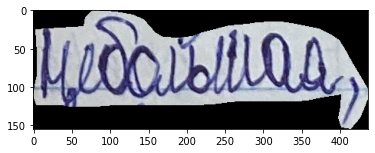

Prediction:  небольшая,


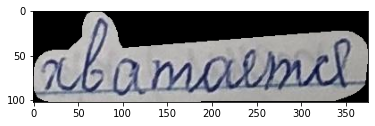

Prediction:  хватается


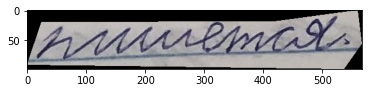

Prediction:  пишется


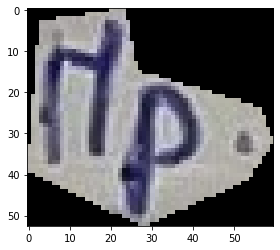

Prediction:  Пр.


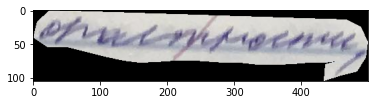

Prediction:  опастности,


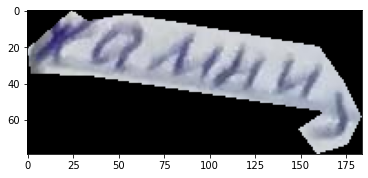

Prediction:  камни,


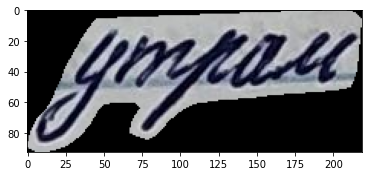

Prediction:  утрам


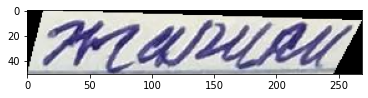

Prediction:  жалили


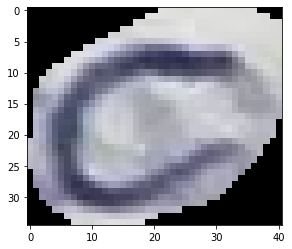

Prediction:  с


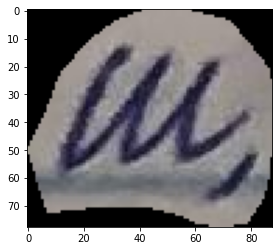

Prediction:  ш,


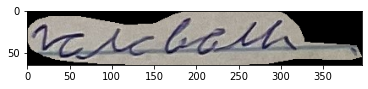

Prediction:  головоли.


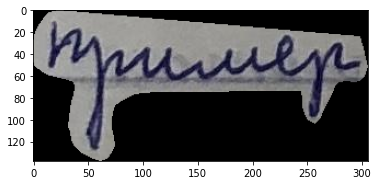

Prediction:  пример


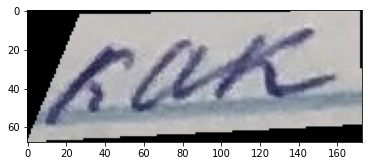

Prediction:  как


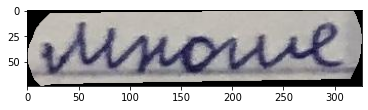

Prediction:  многие


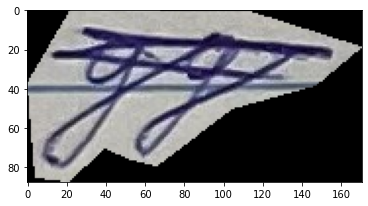

Prediction:  уд


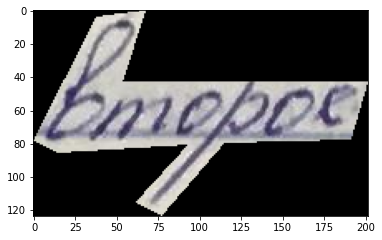

Prediction:  второе


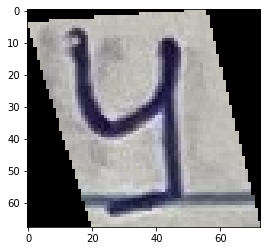

Prediction:  У


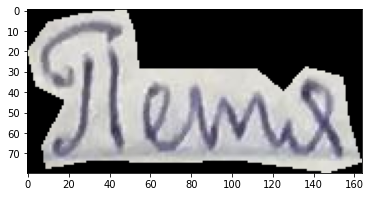

Prediction:  Петя


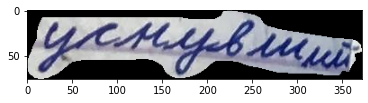

Prediction:  уснувший


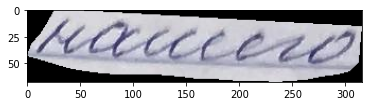

Prediction:  нашего


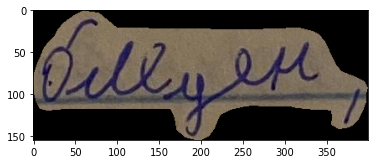

Prediction:  бледен,


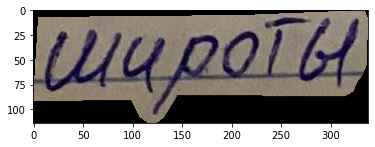

Prediction:  широты


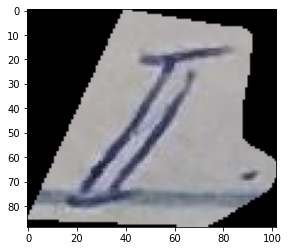

Prediction:  II.


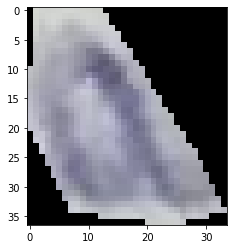

Prediction:  а


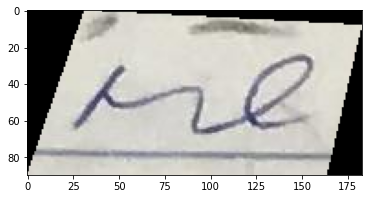

Prediction:  не


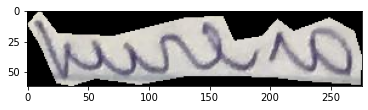

Prediction:  ничего


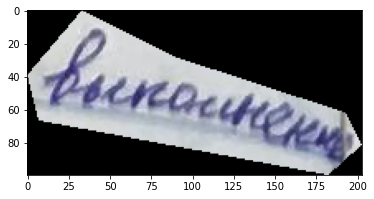

Prediction:  выполнение


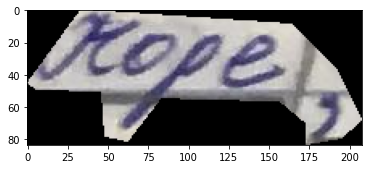

Prediction:  море,


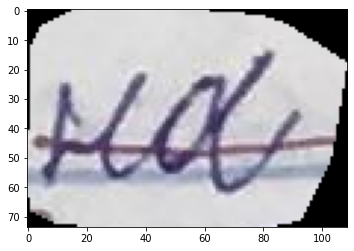

Prediction:  на


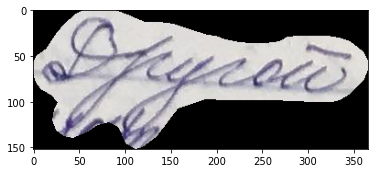

Prediction:  Другой


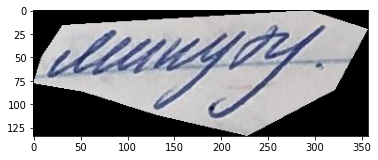

Prediction:  минуту.


KeyboardInterrupt: ignored

In [ ]:
pred_json = {}

count = 0
print_images = True
for img_name in os.listdir('data/final_data/train/images/'):
    img = cv2.imread(f'data/final_data/train/images/{img_name}')

    pred = predictor(img)
    pred_json[img_name] = pred

    if print_images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        print('Prediction: ', predictor(img))
        count += 1

    if count > 30:
        print_images = False

Сохраням submission json с предсказаниями

In [ ]:
with open('data/prediction_HTR.json', 'w') as f:
    json.dump(pred_json, f)